# Processo de obtenção de dados e extração dos dados: Webscrapping
Inicialmente será necessário extrair os dados, pesquisei algumas APIs públicas, mas das que eu encontrei nenhuma era gratuita. Portanto precisaremos recorrer a base de dados de institutos de pesquisas brasileiros. Como eu estou com preguiça de fazer o trabalho manual de baixar um por um, irei fazer um webscrapping básico para obter os dados e ainda dar uma incrementada no projeto.

In [16]:
# Limpando o ambiente
globals().clear()
locals().clear()


In [17]:
# Importando todas bibliotecas necessárias
import requests
import pandas as pd
import seaborn as sb
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


In [18]:
# Importando bases de dados
df_arabica = pd.read_csv(r'C:\Users\super\Downloads\CEPEA_20250209175317.csv')
df_robusto = pd.read_csv(r'C:\Users\super\Downloads\CEPEA_20250209175329.csv')


In [20]:
# Cria nova coluna de tipificação de safras de café 
df_arabica['tipo'] = None
df_robusto['tipo'] = None

# Insere as informações dos tipos de safra
df_arabica['tipo'].fillna('Arabica', inplace=True)
df_robusto['tipo'].fillna('Robusta', inplace=True)


C:\Users\super\AppData\Local\Temp\ipykernel_36856\30562827.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_arabica['tipo'].fillna('Arabica', inplace=True)
C:\Users\super\AppData\Local\Temp\ipykernel_36856\30562827.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [21]:
# Removendo linhas desnecessarias
df_arabica = df_arabica.iloc[3:]  #Removendo as 3 primeiras linhas
df_robusto = df_robusto.iloc[3:]  #Removendo as 3 primeiras linhas




In [22]:
# Verificando o nome das colunas para padronização
print(df_arabica.columns.tolist())
print(df_robusto.columns.tolist())

['INDICADOR DO CAFÉ ARÁBICA CEPEA/ESALQ', 'Unnamed: 1', 'Unnamed: 2', 'tipo']
['INDICADOR DO CAFÉ ROBUSTA CEPEA/ESALQ', 'Unnamed: 1', 'Unnamed: 2', 'tipo']


In [23]:
# Padronizando colunas
df_arabica.rename(columns={'INDICADOR DO CAFÉ ARÁBICA CEPEA/ESALQ': 'data', 'Unnamed: 1': 'valor_reais', 'Unnamed: 2': 'valor_dolar'}, inplace=True)
df_robusto.rename(columns={'INDICADOR DO CAFÉ ROBUSTA CEPEA/ESALQ': 'data', 'Unnamed: 1': 'valor_reais', 'Unnamed: 2': 'valor_dolar'}, inplace=True)



In [24]:
# Checando o resultado
print(df_arabica.columns.tolist())
print(df_robusto.columns.tolist())

# tudo ok

['data', 'valor_reais', 'valor_dolar', 'tipo']
['data', 'valor_reais', 'valor_dolar', 'tipo']


In [25]:
# Une os dois data sets em apenas um completo
# df_cafe = pd.concat([df_arabica, df_robusto], ignore_index=True)
# df_cafe = pd.merge(df_arabica, df_robusto, on='INDICADOR DO CAFÉ ARÁBICA CEPEA/ESALQ')
df_cafe = pd.concat([df_arabica, df_robusto], ignore_index=True)

In [26]:
# Padroniza a coluna de data para o formato Date
df_cafe['data'] = pd.to_datetime(df_cafe['data'], format='%d/%m/%Y')

# Converter 'valor_reais' para numérico (forçando erros a NaN)
df_cafe['valor_reais'] = pd.to_numeric(df_cafe['valor_reais'], errors='coerce')
df_cafe['valor_dolar'] = pd.to_numeric(df_cafe['valor_dolar'], errors='coerce')

In [29]:
# Cria uma variavel para indicar mês e ano
df_cafe['ano_mes'] = df_cafe['data'].dt.to_period('M')

# Calcula a média mensal para plotar algo mais visualmente agradavel
df_media_mensal = df_cafe.groupby(['ano_mes', 'tipo'])['valor_reais'].mean().reset_index()

# Renomeia a coluna
df_media_mensal.rename(columns={'valor': 'valor_medio_mensal'}, inplace=True)

# Arredonda casa decimais do valor medio
df_media_mensal['valor_reais'] = df_media_mensal['valor_reais'].round(1)

# Exibe o resultado
print(df_media_mensal.head())

   ano_mes     tipo  valor_reais
0  1996-09  Arabica        116.8
1  1996-10  Arabica        116.7
2  1996-11  Arabica        119.2
3  1996-12  Arabica        126.1
4  1997-01  Arabica        159.8


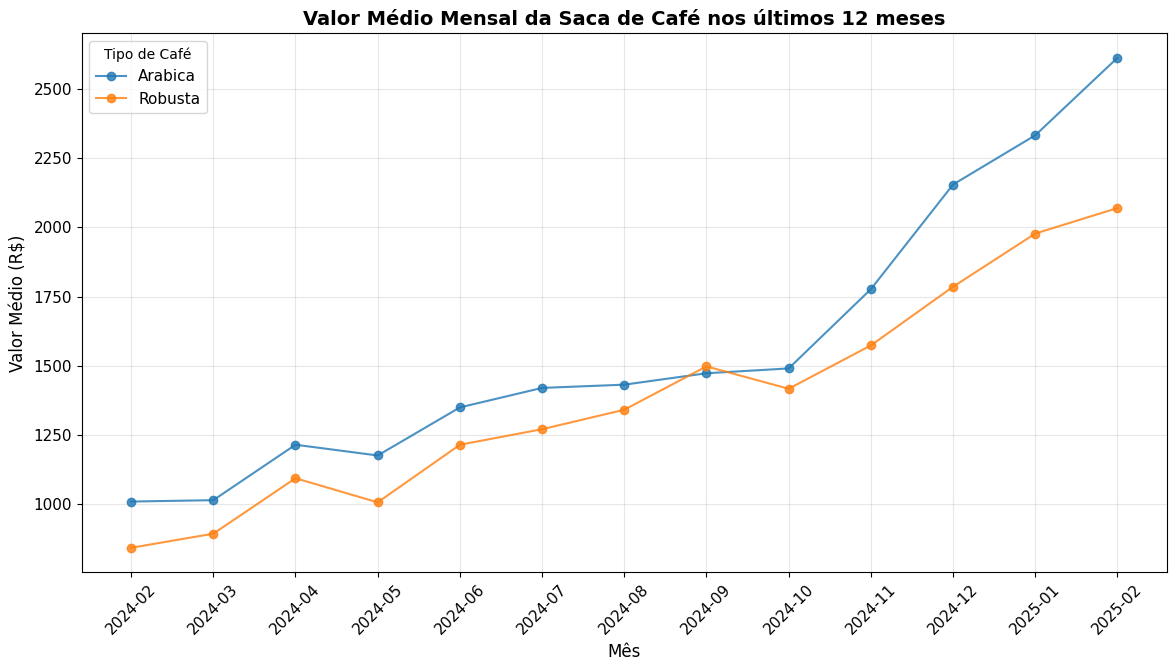

In [35]:
# Define o período de 1 ano: de fevereiro de 2024 a fevereiro de 2025
data_inicio = pd.Period('2024-02', freq='M')
data_fim = pd.Period('2025-02', freq='M')

# Filtra apenas os meses dentro do período desejado
df_filtrado = df_media_mensal[(df_media_mensal['ano_mes'] >= data_inicio) & (df_media_mensal['ano_mes'] <= data_fim)]

# Define deslocamentos diferentes para os rótulos por tipo de café
offsets = {'Robusta': 0.8, 'Arabica': 1.2}

# Define cores personalizadas para cada tipo de café
cores = {'Robusta': '#FF7F0E', 'Arabica': '#1F77B4'}

# Cria a figura do gráfico
plt.figure(figsize=(14, 7))

# Percorre os tipos de café únicos para traçar as linhas
for tipo in df_filtrado['tipo'].unique():
    subset = df_filtrado[df_filtrado['tipo'] == tipo]  # Filtra os dados do tipo atual
    cor = cores.get(tipo, 'gray')  # Obtém a cor definida ou usa cinza
    
    # Plota a linha com marcadores
    plt.plot(subset['ano_mes'].dt.strftime('%Y-%m'), subset['valor_reais'], 
             marker='o', linestyle='-', alpha=0.8, label=tipo, color=cor)
    
    # Alterna deslocamento dos rótulos para evitar sobreposição
    deslocamentos = np.where(np.arange(len(subset)) % 2 == 0, offsets[tipo], -offsets[tipo])

    # Adiciona rótulos nos pontos
    #for x, y, d in zip(subset['ano_mes'].dt.strftime('%Y-%m'), subset['valor_reais'], deslocamentos):
        #plt.text(x, y + d, f'R$ {y:.0f}', ha='center', va='center', fontsize=9, color='black',
                 #bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.2'))

# Configurações do gráfico
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Valor Médio (R$)', fontsize=12)
plt.title('Valor Médio Mensal da Saca de Café nos últimos 12 meses', fontsize=14, fontweight='bold')

plt.legend(title="Tipo de Café", fontsize=11)
plt.grid(alpha=0.3)
plt.show()




period[M]
